In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# UMAPS for cvae multi of adaptation model

In [37]:
from evoscaper.scripts.init_from_hpos import init_from_hpos
from evoscaper.utils.math import arrayise
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from common import get_model_latent_space_dimred
from evoscaper.utils.visualise import visualize_dimred_adapt_sp
from evoscaper.utils.preprocess import make_datetime_str, format_with_subscript

import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import os

sns.set_style('whitegrid')


In [38]:
top_write_dir = os.path.join('data', '22_umaps_multi', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)


# Load data 

In [39]:
# fn_dataset = 'data/simulate_circuits/2025_02_11__13_56_51/tabulated_mutation_info.json'
# dataset = load_json_as_dict(fn_dataset)

# Functions for loading models

In [40]:
fn_hpos = 'data/cvae_multi/2025_09_01__22_52_46/df_hpos.json'
hpos = pd.DataFrame(load_json_as_dict(fn_hpos))
for k in hpos.columns:
    if 'filename' in k:
        hpos.loc[:, k] = hpos[k].apply(lambda x: '../' + x if x.startswith('data') else x)
        hpos.loc[:, k] = hpos[k].apply(lambda x: x.replace('notebooks/', '') if isinstance(x, str) else x)
(
    rng, rng_model, rng_dataset,
    config_norm_x, config_norm_y, config_filter, config_optimisation, config_dataset, config_training, config_model,
    data, x_cols, df,
    x, cond, y, x_train, cond_train, y_train, x_val, cond_val, y_val,
    total_ds, n_batches, BATCH_SIZE, x_datanormaliser, x_methods_preprocessing, y_datanormaliser, y_methods_preprocessing,
    params, encoder, decoder, model, h2mu, h2logvar, reparam
) = init_from_hpos(hpos.iloc[1])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [41]:
def load_params(hpo):

    fn_saves = hpo['filename_saved_model']
    saves_loaded = load_json_as_dict(fn_saves)
    p = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
    p = arrayise(p)
    
    return p

# Functions for UMAP + visualisation

In [42]:
use_h = False
perplexity = 30
n_show = 20000
random_state = 0
method = 'UMAP'
input_species = data['sample_name'].dropna().unique()
labels_x = list(itertools.product(input_species, input_species))
labels_x = sorted(set(tuple(sorted(labels_x[i]))
                for i in range(len(labels_x))))
labels_cond = ['adaptation', 'Log sensitivity', 'Log precision']


In [65]:
def run_umap(hpo):
    p = load_params(hpo)
    result_dimred, idxs_show, cond_unique, cond_binned, x_bin_all, x_rev_all, cond_rev_all, emb, h_all, z_all = get_model_latent_space_dimred(
        p, rng, encoder, h2mu, h2logvar,
        x, cond, use_h,
        y_datanormaliser, y_methods_preprocessing,
        config_dataset, x_datanormaliser, x_methods_preprocessing,
        hpo,
        method=method, n_show=n_show, random_state=random_state,
        perplexity=perplexity
    )
    print(idxs_show.shape)

    visualize_dimred_adapt_sp(result_dimred, df[labels_cond].values[idxs_show],
                              np.log10(
                                  x_bin_all[idxs_show]) if config_norm_x.logscale else x_bin_all[idxs_show],
                              labels_cond=labels_cond,
                              labels_x=labels_x, method=method,
                              save_path=os.path.join(top_write_dir, f'umap_big_{hpo["index"]}.png'), s=70, sort=False, sort_random=True)

# Loop for loading and visualising

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(8963,)


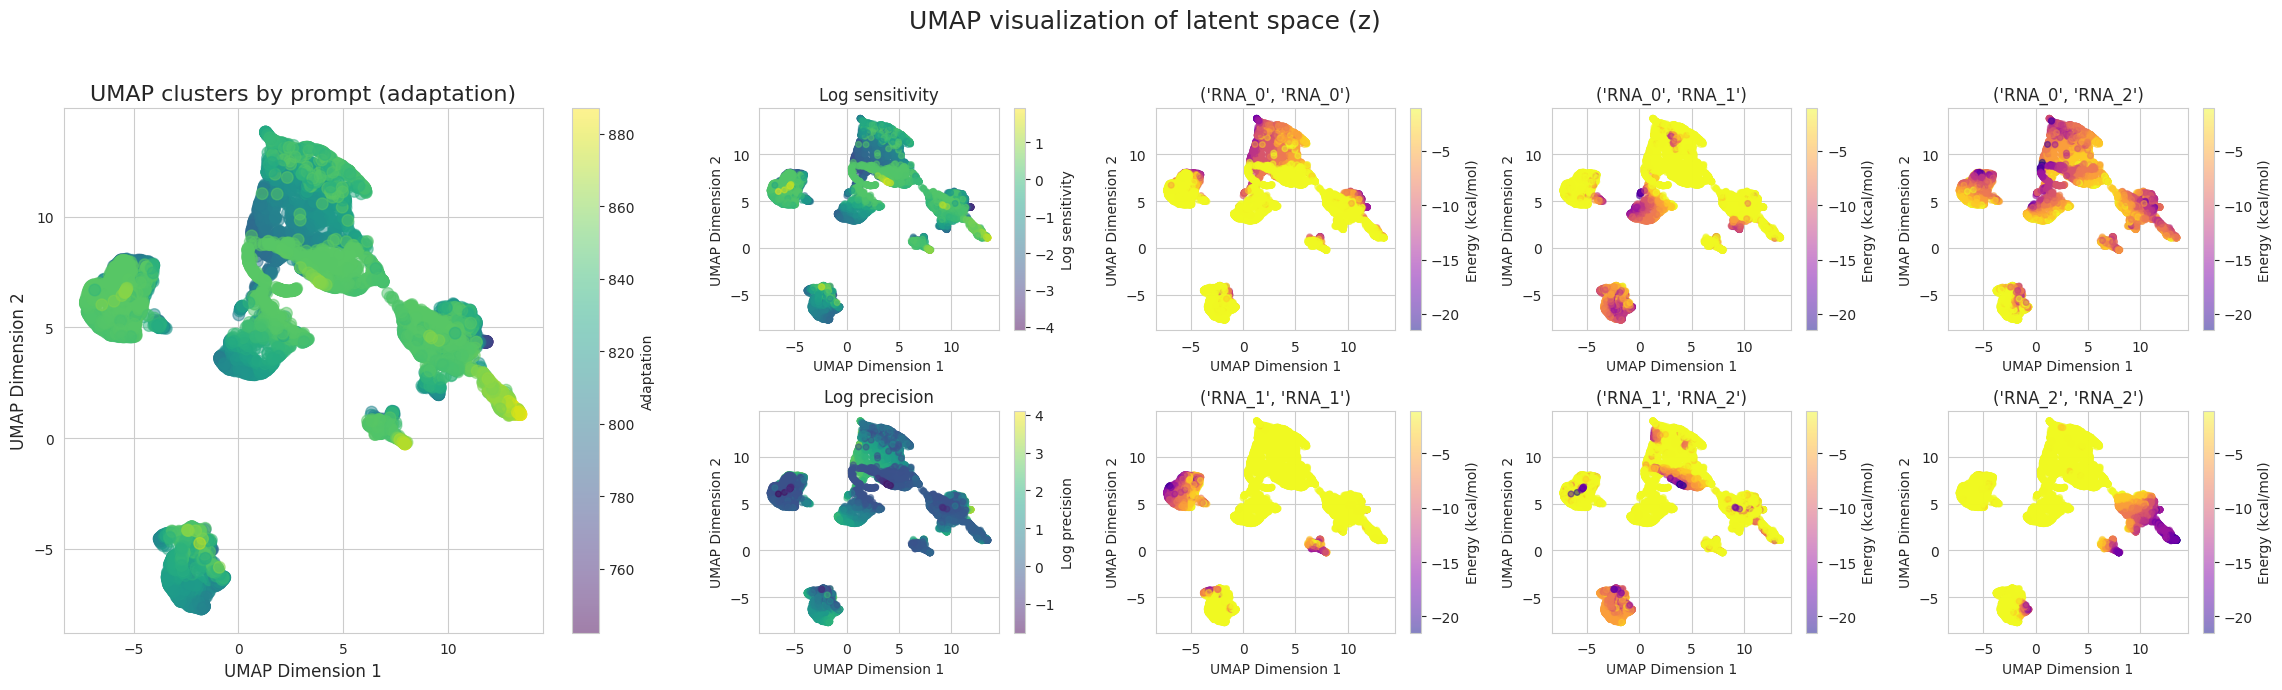

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(8963,)


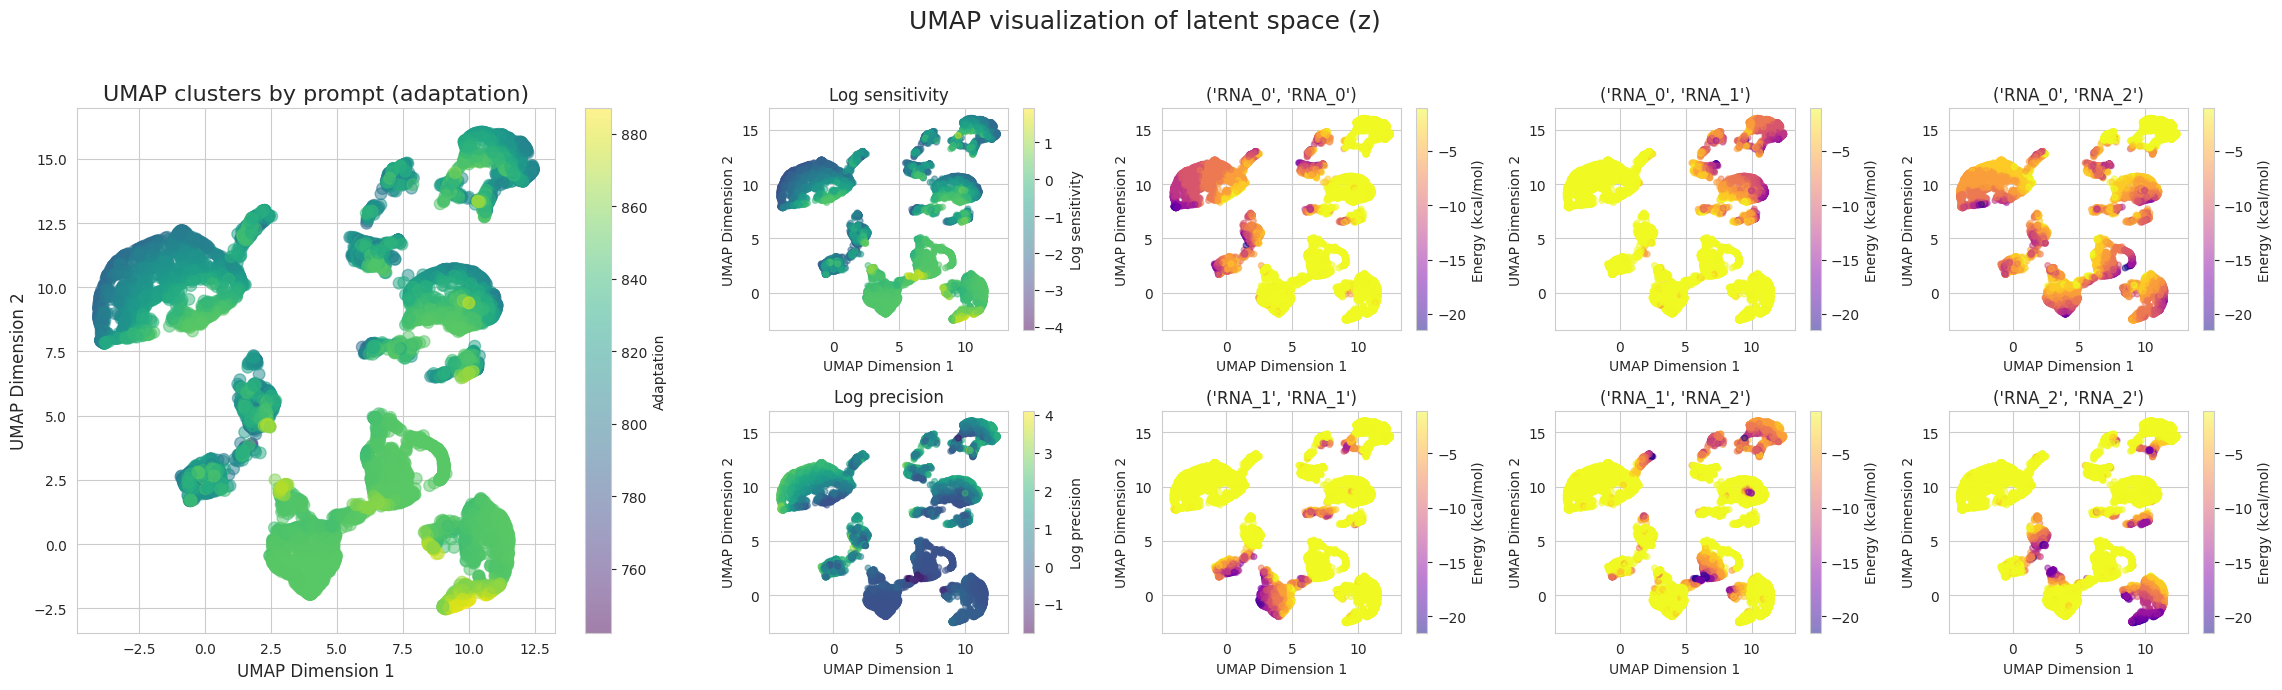

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
for i in hpos.index:
    hpo = hpos.iloc[[i]].reset_index().iloc[0].to_dict()
    p = run_umap(hpo)